<a href="https://colab.research.google.com/github/aseasyaspie/KDDFinalProject/blob/main/KDDFinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Goal - Predict player position based on stats 
Nitish - In order to get more data, I think we should pull out all player game data and join it with Player positions such that we are able to predict a players position based on their stat line in a game

perform clustering to see if there are more than 5 clusters and intergroup analysis 

predict assists?

do certain stats effect team win pct? such as pg assist/turnover ratio


In [ ]:
!pip install kaggle
!mkdir ~/.kaggle
!mkdir .kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists
mkdir: cannot create directory ‘.kaggle’: File exists


In [ ]:
import json
token = {'username':'architbose','key':'961e353f3c7e099130d68a9d7caa9d79'}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [ ]:
!cp /content/.kaggle/kaggle.json .kaggle/kaggle.json

cp: '/content/.kaggle/kaggle.json' and '.kaggle/kaggle.json' are the same file


In [ ]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle config set -n path -v{/content}


- path is now set to: {/content}


In [ ]:
!kaggle datasets list -s "NBA Players"

ref                                                         title                                                size  lastUpdated          downloadCount  
----------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
justinas/nba-players-data                                   NBA Players                                         490KB  2020-03-08 17:32:54          10475  
drgilermo/nba-players-stats                                 NBA Players stats since 1950                          2MB  2018-04-27 12:23:27          34696  
drgilermo/nba-players-stats-20142015                        NBA Players Stats - 2014-2015                        33KB  2017-05-03 17:46:24           4977  
nathanlauga/nba-games                                       NBA games data                                       19MB  2021-05-27 16:45:02           8680  
isaienkov/nba2k20-player-dataset                            NBA 

In [ ]:
!kaggle datasets download -d drgilermo/nba-players-stats -p /content

nba-players-stats.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip \*.zip

Archive:  nba-players-stats.zip
replace Players.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace Seasons_Stats.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace player_data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [ ]:
import pandas as pd
d = pd.read_csv('Players.csv')
d.head()

,Unnamed: 0,Player,height,weight,collage,born,birth_city,birth_state
0,0,Curly Armstrong,180.0,77.0,Indiana University,1918.0,NaN,NaN
1,1,Cliff Barker,188.0,83.0,University of Kentucky,1921.0,Yorktown,Indiana
2,2,Leo Barnhorst,193.0,86.0,University of Notre Dame,1924.0,NaN,NaN
3,3,Ed Bartels,196.0,88.0,North Carolina State University,1925.0,NaN,NaN
4,4,Ralph Beard,178.0,79.0,University of Kentucky,1927.0,Hardinsburg,Kentucky


In [ ]:
df_height_weight = d.drop(['Unnamed: 0','collage','born','birth_city','birth_state'],axis=1)
df_height_weight.head()

,Player,height,weight
0,Curly Armstrong,180.0,77.0
1,Cliff Barker,188.0,83.0
2,Leo Barnhorst,193.0,86.0
3,Ed Bartels,196.0,88.0
4,Ralph Beard,178.0,79.0


In [ ]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np


In [ ]:
!pip install kneed

In [ ]:
def get_NBA_player_data(year):
  url = "https://www.basketball-reference.com/leagues/NBA_{}_per_game.html".format(year)
  # this is the HTML from the given URL
  html = urlopen(url)
  soup = BeautifulSoup(html)
  # use findALL() to get the column headers
  soup.findAll('tr', limit=2)
  # use getText()to extract the text we need into a list
  headers = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')]
  # exclude the first column as we will not need the ranking order from Basketball Reference for the analysis
  headers = headers[1:]
  rows = soup.findAll('tr')[1:]
  player_stats = [[td.getText() for td in rows[i].findAll('td')]
              for i in range(len(rows))]
  stats = pd.DataFrame(player_stats, columns = headers)
  stats = stats.dropna()
  return stats

In [ ]:
def get_player_stats_per_decade(start_year):
  player_stats = None
  frames = []
  for year in range(start_year,start_year+11):
    stats = get_NBA_player_data(year)
    frames.append(stats)
  player_stats = pd.concat(frames)
  return player_stats

In [ ]:
def clean_dataframe(stats):
  stats['Pos']= stats['Pos'].astype(str)
  y = stats['Pos']
  stats.drop(columns=['Player', 'Tm'], inplace=True)
  stats['3P%'] = stats['3P%'].replace('', '.000')
  stats['FG%'] = '0' + stats['FG%']
  stats['3P%']  = '0' + stats['3P%']
  stats['2P%']  = '0' + stats['2P%']
  stats['eFG%']  = '0' + stats['eFG%']
  stats['FT%']  = '0' + stats['FT%']
  for column in stats.columns[1:]:
    stats[column] = stats[column].astype(float)
  return stats

In [ ]:
def merge_players(main_df,height_weight_df):
  return main_df.merge(height_weight_df,on='Player')

In [ ]:
player_stats_2010s = clean_dataframe(get_player_stats_per_decade(2010))
player_stats_2000s = clean_dataframe(get_player_stats_per_decade(2000))
player_stats_1990s = clean_dataframe(get_player_stats_per_decade(1990))

# player_stats_1980s = clean_dataframe(get_player_stats_per_decade(1980))

In [ ]:
prediction_dataset = pd.concat([player_stats_2010s,player_stats_2000s,player_stats_1990s])

#drop players who have less than 10 mp per game
mp_prediction_dataset = prediction_dataset[prediction_dataset.MP >= 10]

mp_prediction_dataset_labels = mp_prediction_dataset['Pos']
mp_prediction_dataset.drop(columns=['Pos'],inplace=True)
mp_prediction_dataset

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Age,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,24.0,82.0,75.0,27.1,3.3,7.1,0.465,1.3,3.0,0.434,2.0,4.1,0.488,0.557,0.9,1.2,0.735,0.7,2.4,3.1,1.7,0.6,0.4,0.9,2.7,8.8
2,24.0,78.0,78.0,37.5,7.4,15.0,0.495,0.1,0.2,0.313,7.4,14.8,0.498,0.497,2.9,3.9,0.757,2.5,5.6,8.0,2.1,0.9,0.6,1.3,3.0,17.9
5,34.0,80.0,80.0,35.2,5.8,12.2,0.477,1.8,5.0,0.363,4.0,7.2,0.556,0.551,2.9,3.2,0.913,0.6,2.6,3.2,2.6,0.8,0.3,1.6,2.3,16.3
6,28.0,54.0,8.0,16.5,2.4,4.7,0.510,0.0,0.1,0.000,2.4,4.6,0.520,0.510,1.3,2.2,0.605,1.0,1.7,2.7,1.3,1.1,0.4,1.2,2.0,6.1
7,33.0,52.0,38.0,27.3,3.0,8.6,0.348,1.1,3.2,0.345,1.9,5.3,0.349,0.413,1.1,1.6,0.728,0.3,2.2,2.5,3.4,1.0,0.2,1.8,2.0,8.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
508,37.0,79.0,1.0,21.3,3.0,7.2,0.415,0.0,0.0,0.333,3.0,7.2,0.415,0.416,1.7,2.1,0.799,2.5,3.6,6.1,0.6,0.5,0.6,1.2,3.2,7.6
509,25.0,25.0,1.0,20.3,2.4,7.2,0.341,1.2,3.9,0.296,1.3,3.2,0.395,0.422,1.6,2.0,0.765,0.4,1.6,2.0,2.6,0.9,0.1,1.5,1.3,7.6
512,34.0,23.0,1.0,10.8,1.0,2.7,0.371,0.5,1.3,0.379,0.5,1.4,0.364,0.460,0.4,0.6,0.692,0.0,0.7,0.7,1.9,0.5,0.0,0.6,1.0,2.9
514,20.0,72.0,63.0,31.1,4.3,10.5,0.407,0.8,2.7,0.314,3.5,7.9,0.438,0.447,2.6,3.9,0.674,0.9,3.4,4.3,2.8,1.7,0.5,2.3,2.2,12.0


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(mp_prediction_dataset, mp_prediction_dataset_labels, random_state=0)


In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

yy_train = le.fit_transform(y_train)
yy_test = le.fit_transform(y_test)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaler = scaler.fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [ ]:
from sklearn.metrics import accuracy_score


In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf1_model = RandomForestClassifier(n_estimators=500, random_state=1)
rf1_model = rf1_model.fit(X_train_scaled, y_train)
predictions = rf1_model.predict(X_test_scaled)
model_accuracy_score = accuracy_score(y_test, predictions)
print(model_accuracy_score)

0.7153123272526257


In [ ]:
from sklearn import svm
from sklearn.svm import SVC
svm1_model = svm.SVC(kernel='linear', random_state=1)
svm1_model = svm1_model.fit(X_train_scaled, y_train)
predictions = svm1_model.predict(X_test_scaled)
model_accuracy_score = accuracy_score(y_test, predictions)
print(model_accuracy_score)

0.6760641238253179


In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_scaled, y_train)
print('Accuracy of LDA classifier on training set: {:.2f}'
     .format(lda.score(X_train_scaled, y_train)))
print('Accuracy of LDA classifier on test set: {:.2f}'
     .format(lda.score(X_test_scaled, y_test)))

Accuracy of LDA classifier on training set: 0.63
Accuracy of LDA classifier on test set: 0.62


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train_scaled, y_train)
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_train_scaled, y_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test_scaled, y_test)))

Accuracy of K-NN classifier on training set: 0.75
Accuracy of K-NN classifier on test set: 0.61


In [ ]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier().fit(X_train_scaled, y_train)
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_train_scaled, y_train)))
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf.score(X_test_scaled, y_test)))

Accuracy of Decision Tree classifier on training set: 1.00
Accuracy of Decision Tree classifier on test set: 0.60


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
gbt1_model = GradientBoostingClassifier(n_estimators=20, learning_rate=0.75, max_depth=3, random_state=1)
gbt1_model = gbt1_model.fit(X_train_scaled, y_train)
predictions = gbt1_model.predict(X_test_scaled)
model_accuracy_score = accuracy_score(y_test, predictions)
print(model_accuracy_score)

0.5726920950801547


In [ ]:
y_train

440    SF
316    SF
225    PG
626    PG
410    PG
       ..
403    PG
473    PG
45     SG
239    PG
474    SF
Name: Pos, Length: 10851, dtype: object

In [ ]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(500, activation='relu', input_dim=26))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(2, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
model.fit(X_train_scaled, yy_train, epochs=20)

pred_train= model.predict(X_train)
scores = model.evaluate(X_train, yy_train, verbose=0)
print('Accuracy on training data: {}% \n Error on training data: {}'.format(scores[1], 1 - scores[1]))   
 
pred_test= model.predict(X_test)
scores2 = model.evaluate(X_test, yy_test, verbose=0)
print('Accuracy on test data: {}% \n Error on test data: {}'.format(scores2[1], 1 - scores2[1]))    


ValueError: ignored

Highest accuracy score comes from random forests classifier 

Feature0 Age = Importance:0.024552303822033106
Feature1 G = Importance:0.025523986623352143
Feature2 GS = Importance:0.02696216673606043
Feature3 MP = Importance:0.038929989340260394
Feature4 FG = Importance:0.023062709721194206
Feature5 FGA = Importance:0.029091691558310935
Feature6 FG% = Importance:0.03010070568394308
Feature7 3P = Importance:0.03390332438743451
Feature8 3PA = Importance:0.05720524785518021
Feature9 3P% = Importance:0.03765890007805392
Feature10 2P = Importance:0.02154933049083683
Feature11 2PA = Importance:0.026034003479961477
Feature12 2P% = Importance:0.02808825496583459
Feature13 eFG% = Importance:0.027001584336969673
Feature14 FT = Importance:0.023602331202236163
Feature15 FTA = Importance:0.024447896174661247
Feature16 FT% = Importance:0.02995256240821544
Feature17 ORB = Importance:0.06190576592736271
Feature18 DRB = Importance:0.050689081710555
Feature19 TRB = Importance:0.07122085546683307
Feature20 AST = Importance:0.11906979642709865
Feature21 STL = Importa

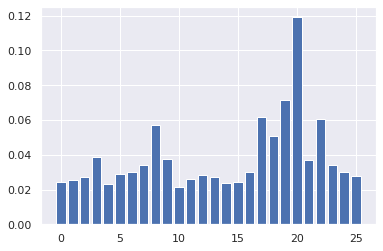

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot
# define dataset
# define the model
model = RandomForestClassifier()
# fit the model
model.fit(X_train_scaled, y_train)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i in range(len(importance)):
  string = ""
  val = X_train.columns[i]
  string = string + "Feature" + str(i) + " " + val + " = Importance:" + str(importance[i])
  print(string)

#for i,v in enumerate(importance):
	#print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [ ]:
feature_df = mp_prediction_dataset.drop(columns=['Age'])

from sklearn.model_selection import train_test_split
newx_train, newx_test, newy_train, newy_test = train_test_split(feature_df, mp_prediction_dataset_labels, random_state=0)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
newscale = scaler.fit(newx_train)
newscaledtrain = newscale.transform(newx_train)
newscaledtest = newscale.transform(newx_test)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf1_model = RandomForestClassifier(n_estimators=500, random_state=1)
rf1_model = rf1_model.fit(newscaledtrain, newy_train)
predictions = rf1_model.predict(newscaledtest)
model_accuracy_score = accuracy_score(newy_test, predictions)
print(model_accuracy_score)

0.7086788280818132


### **Adding Height and Weight**

In [ ]:
player_stats_2010s = clean_dataframe(merge_players(get_player_stats_per_decade(2010),df_height_weight))
player_stats_2000s = clean_dataframe(merge_players(get_player_stats_per_decade(2000),df_height_weight))
player_stats_1990s = clean_dataframe(merge_players(get_player_stats_per_decade(1990),df_height_weight))

In [ ]:
prediction_dataset = pd.concat([player_stats_2010s,player_stats_2000s,player_stats_1990s])

#drop players who have less than 10 mp per game
mp_prediction_dataset = prediction_dataset[prediction_dataset.MP >= 10]

mp_prediction_dataset_labels = mp_prediction_dataset['Pos']
mp_prediction_dataset.drop(columns=['Pos'],inplace=True)
mp_prediction_dataset

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Age,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,height,weight
0,24.0,82.0,75.0,27.1,3.3,7.1,0.465,1.3,3.0,0.434,2.0,4.1,0.488,0.557,0.9,1.2,0.735,0.7,2.4,3.1,1.7,0.6,0.4,0.9,2.7,8.8,196.0,95.0
1,25.0,69.0,69.0,33.7,4.5,9.1,0.498,1.5,3.6,0.423,3.0,5.5,0.546,0.581,2.0,2.4,0.847,0.7,3.0,3.6,2.4,0.5,0.4,1.0,2.2,12.6,196.0,95.0
2,26.0,62.0,62.0,33.6,5.3,11.3,0.471,1.4,3.6,0.398,3.9,7.7,0.504,0.534,3.2,4.0,0.798,0.6,2.5,3.2,2.4,0.6,0.2,1.4,2.2,15.2,196.0,95.0
3,27.0,64.0,64.0,36.0,6.2,14.1,0.439,1.1,3.8,0.300,5.1,10.4,0.489,0.478,3.0,3.5,0.857,0.5,3.3,3.7,3.2,0.6,0.2,2.2,2.1,16.5,196.0,95.0
4,28.0,73.0,73.0,35.0,6.4,13.8,0.459,1.8,4.1,0.427,4.6,9.7,0.473,0.522,3.8,4.6,0.815,0.4,3.2,3.6,3.4,0.5,0.0,2.0,1.9,18.2,196.0,95.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5196,22.0,73.0,53.0,29.7,4.7,9.2,0.511,0.4,1.1,0.359,4.3,8.1,0.531,0.532,1.8,2.2,0.826,1.2,2.5,3.7,2.8,0.8,0.3,1.1,2.4,11.6,198.0,95.0
5197,22.0,81.0,27.0,23.3,3.1,7.4,0.415,0.6,1.9,0.293,2.5,5.5,0.458,0.453,1.4,1.7,0.807,0.3,1.8,2.0,4.3,1.1,0.1,1.9,1.6,8.1,188.0,83.0
5201,22.0,72.0,29.0,25.0,2.9,7.4,0.399,0.4,1.7,0.262,2.5,5.7,0.440,0.429,1.9,2.9,0.660,2.0,4.0,6.1,1.6,0.8,0.3,1.6,2.3,8.3,201.0,118.0
5202,23.0,3.0,0.0,13.7,0.3,2.0,0.167,0.0,0.0,0.000,0.3,2.0,0.167,0.167,0.7,2.0,0.333,0.3,0.7,1.0,1.7,0.0,0.0,1.0,1.3,1.3,188.0,86.0


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(mp_prediction_dataset, mp_prediction_dataset_labels, random_state=0)


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaler = scaler.fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf1_model = RandomForestClassifier(n_estimators=500, random_state=1)
rf1_model = rf1_model.fit(X_train_scaled, y_train)
predictions = rf1_model.predict(X_test_scaled)
model_accuracy_score = accuracy_score(y_test, predictions)
print(model_accuracy_score)

0.7894413750767342


In [ ]:
from sklearn import svm
from sklearn.svm import SVC
svm1_model = svm.SVC(kernel='linear', random_state=1)
svm1_model = svm1_model.fit(X_train_scaled, y_train)
predictions = svm1_model.predict(X_test_scaled)
model_accuracy_score = accuracy_score(y_test, predictions)
print(model_accuracy_score)

0.7130141190914672


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot
# define dataset
# define the model
model = RandomForestClassifier()
# fit the model
model.fit(X_train_scaled, y_train)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i in range(len(importance)):
  string = ""
  val = X_train.columns[i]
  string = string + "Feature" + str(i) + val + " = Importance:" + str(importance[i])
  print(string)

#for i,v in enumerate(importance):
	#print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

### **KMeans Clustering**

In [ ]:
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [ ]:
labels_2010s = player_stats_2010s['Pos']
player_stats_2010s.drop(columns=['Pos'],inplace=True)
labels_2000s = player_stats_2000s['Pos']
player_stats_2000s.drop(columns=['Pos'],inplace=True)
labels_1990s = player_stats_1990s['Pos']
player_stats_1990s.drop(columns=['Pos'],inplace=True)

player_stats_2000s

,Age,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,height,weight
0,25.0,61.0,56.0,25.9,4.5,10.6,0.424,0.0,0.4,0.130,4.4,10.2,0.435,0.426,2.4,3.2,0.756,1.7,3.1,4.8,1.6,1.0,0.5,1.7,2.4,11.4,198.0,101.0
1,25.0,46.0,46.0,26.2,4.8,11.2,0.433,0.0,0.5,0.095,4.8,10.7,0.447,0.435,2.5,3.3,0.762,1.7,3.5,5.2,1.6,1.2,0.3,1.9,2.5,12.2,198.0,101.0
2,25.0,15.0,10.0,24.9,3.4,8.7,0.389,0.1,0.1,0.500,3.3,8.6,0.388,0.393,2.1,2.8,0.738,1.6,1.9,3.5,1.7,0.4,0.8,1.3,2.1,8.9,198.0,101.0
3,26.0,29.0,12.0,14.5,1.5,3.8,0.387,0.1,0.3,0.400,1.3,3.5,0.386,0.405,0.7,1.2,0.583,0.5,1.6,2.0,0.8,0.5,0.4,1.2,1.9,3.8,198.0,101.0
4,27.0,24.0,12.0,18.4,2.3,6.1,0.374,0.0,0.1,0.500,2.3,6.0,0.372,0.378,1.0,1.4,0.727,1.7,1.8,3.5,1.0,0.8,0.4,1.1,2.3,5.6,198.0,101.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5499,22.0,68.0,13.0,13.0,1.1,1.9,0.588,0.0,0.0,0.000,1.1,1.9,0.588,0.588,0.8,1.4,0.581,1.3,2.3,3.6,0.2,0.2,1.3,0.6,2.4,3.1,221.0,119.0
5500,22.0,73.0,17.0,25.6,5.5,12.1,0.451,1.6,4.3,0.374,3.8,7.8,0.493,0.517,2.0,2.4,0.814,1.0,1.9,2.9,1.6,0.8,0.2,1.0,1.7,14.5,193.0,92.0
5501,23.0,24.0,10.0,32.6,5.8,11.8,0.495,1.4,3.8,0.359,4.5,8.0,0.560,0.553,2.2,2.6,0.839,0.8,3.8,4.6,2.8,1.0,0.3,1.2,2.0,15.2,201.0,86.0
5502,22.0,78.0,9.0,22.6,3.3,8.3,0.401,0.4,1.3,0.310,2.9,7.1,0.417,0.425,1.3,1.8,0.715,0.6,3.9,4.5,2.9,0.6,0.1,1.6,1.6,8.4,198.0,99.0


In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

labels_2010s = le.fit_transform(labels_2010s)
n_clusters_2010s = len(le.classes_)
labels_2000s = le.fit_transform(labels_2000s)
n_clusters_2000s = len(le.classes_)
labels_1990s = le.fit_transform(labels_1990s)
n_clusters_1990s = len(le.classes_)


In [ ]:
list(le.inverse_transform([0,1,2,3,4]))

In [ ]:
le.class

In [ ]:
kmeansx_train, kmeansx_test, kmeansy_train, kmeansy_test = train_test_split(player_stats_2010s, labels_2010s, random_state=0)

In [ ]:
scaler = StandardScaler()

scaled_1990s = scaler.fit_transform(player_stats_1990s)
scaled_2000s = scaler.fit_transform(player_stats_2000s)
scaled_2010s = scaler.fit_transform(player_stats_2010s)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
df2010 = pca.fit_transform(scaled_2010s)

In [ ]:
from sklearn.cluster import KMeans
 
#Initialize the class object
kmeans = KMeans(n_clusters= 3)
 
#predict the labels of clusters.
label = kmeans.fit_predict(df2010)

print(label)

[1 1 1 ... 2 2 0]


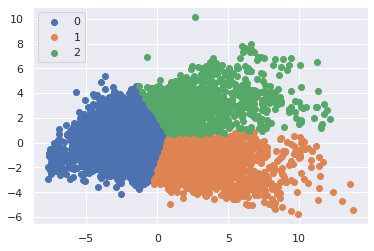

In [ ]:
u_labels = np.unique(label)
 
#plotting the results:
 
for i in u_labels:
    plt.scatter(df2010[label == i , 0] , df2010[label == i , 1] , label = i)
plt.legend()
plt.show()

In [ ]:
from sklearn.cluster import KMeans
 
#Initialize the class object
kmeans = KMeans(n_clusters= 5)
 
#predict the labels of clusters.
label = kmeans.fit_predict(df2010)

print(label)

[0 0 2 ... 1 1 3]


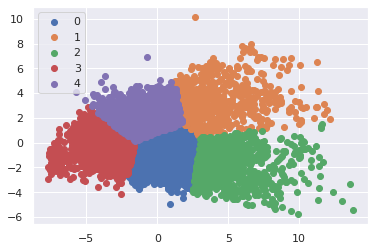

In [ ]:
u_labels = np.unique(label)
 
#plotting the results:
 
for i in u_labels:
    plt.scatter(df2010[label == i , 0] , df2010[label == i , 1] , label = i)
plt.legend()
plt.show()

**Clustering on 1990s players**

In [ ]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

# A list holds the SSE values for each k
sse1990 = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_1990s)
    sse1990.append(kmeans.inertia_)

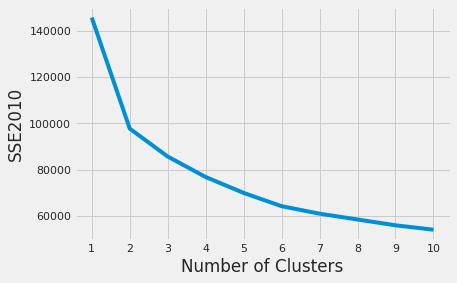

In [ ]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

# A list holds the SSE values for each k
sse1990 = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_1990s)
    sse1990.append(kmeans.inertia_)

plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse1990)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE2010")
plt.show()

In [ ]:
 #elbow method
 
 plt.style.use("fivethirtyeight")
 plt.plot(range(1, 11), sse1990)
 plt.xticks(range(1, 11))
 plt.xlabel("Number of Clusters")
 plt.ylabel("SSE1990")
 plt.show()

In [ ]:
kl = KneeLocator(
    range(1, 11), sse1990, curve="convex", direction="decreasing"
)
kl.elbow


**Clustering on 2000s players**

In [ ]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

# A list holds the SSE values for each k
sse2000 = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_2000s)
    sse2000.append(kmeans.inertia_)

In [ ]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse2000)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE2000")
plt.show()

In [ ]:
kl = KneeLocator(
    range(1, 11), sse2000, curve="convex", direction="decreasing"
)
kl.elbow

**Clustering on 2010s players**

In [ ]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

# A list holds the SSE values for each k
sse2010 = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_2010s)
    sse2010.append(kmeans.inertia_)

In [ ]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse2010)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE2010")
plt.show()

In [ ]:
kl = KneeLocator(
    range(1, 11), sse2000, curve="convex", direction="decreasing"
)
kl.elbow

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons
from sklearn.metrics import adjusted_rand_score


In [ ]:
np.isnan(X_train.any())
np.isfinite(X_train.all())

In [ ]:

#print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
#print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
#print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))